=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===

=== SCENARIO SUMMARY ===
                 soy_land_pc  total_land_pc   water_pc  protein_pc
scenario                                                          
40/60                 186.31         410.12  366702.64       22.00
40/60 + chicken       225.79         511.31  453202.64       26.60
50/50                 195.65         468.47  410217.10       22.00
Current               312.26         981.24  814429.98       28.41
Red meat cap          249.66         626.44  528650.50       22.00

=== PRODUCT-LEVEL FEED LAND SUMMARY (per kg product) ===
            soy_share  soy_land  non_soy_land  total_land  protein_g_kg  \
product                                                                   
pork             0.12     1.581         4.680       6.261           230   
chicken          0.20     1.974         3.086       5.060           230   
beef             0.12     6.692        13.490      20.182           340   
other_meat       0.12

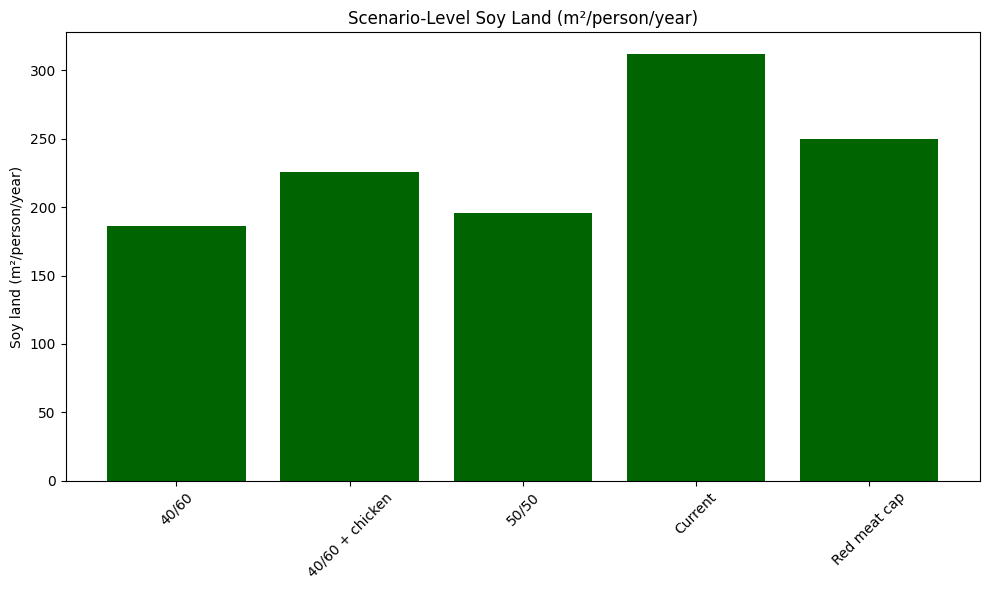

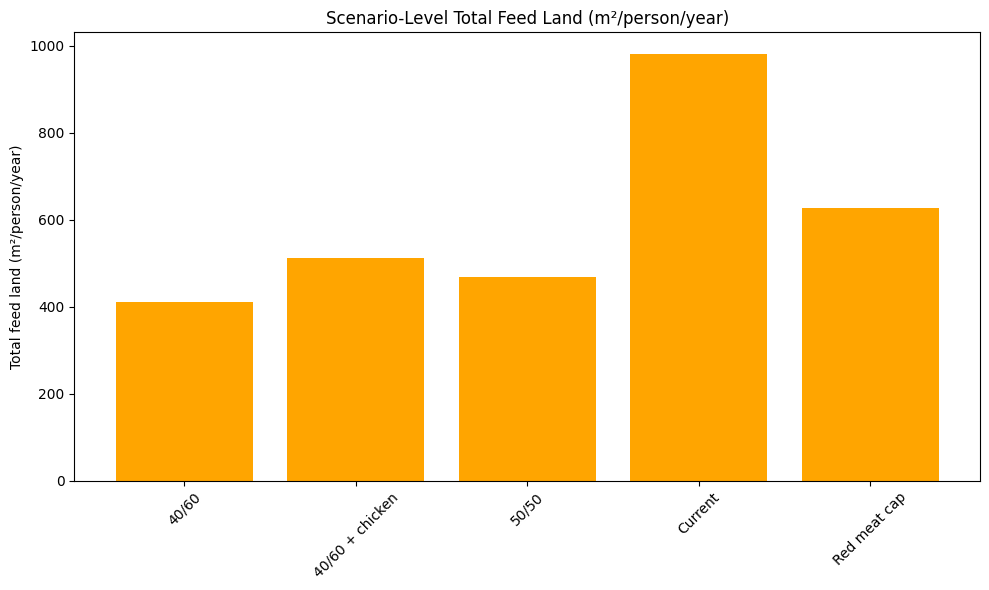

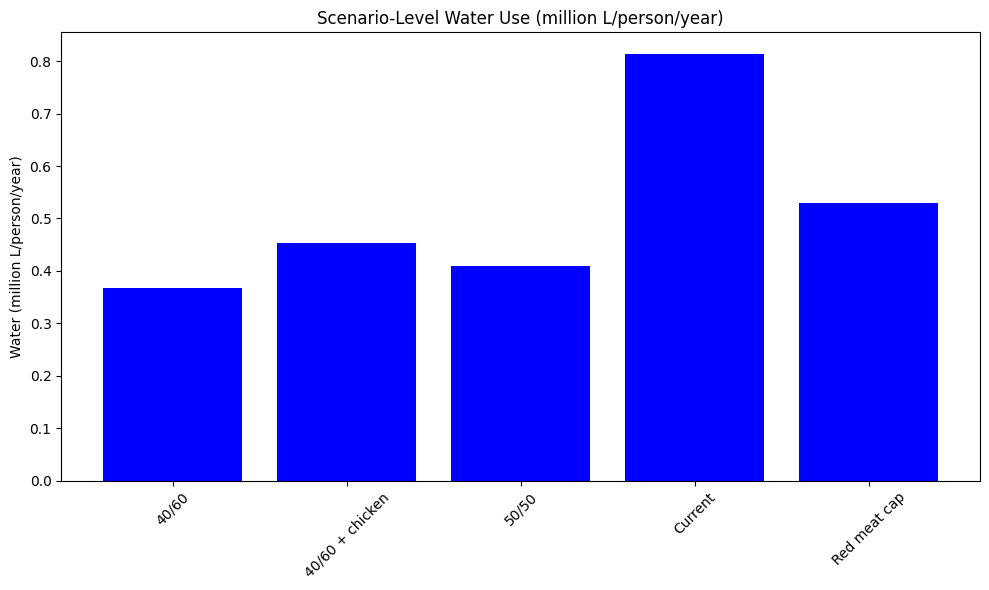

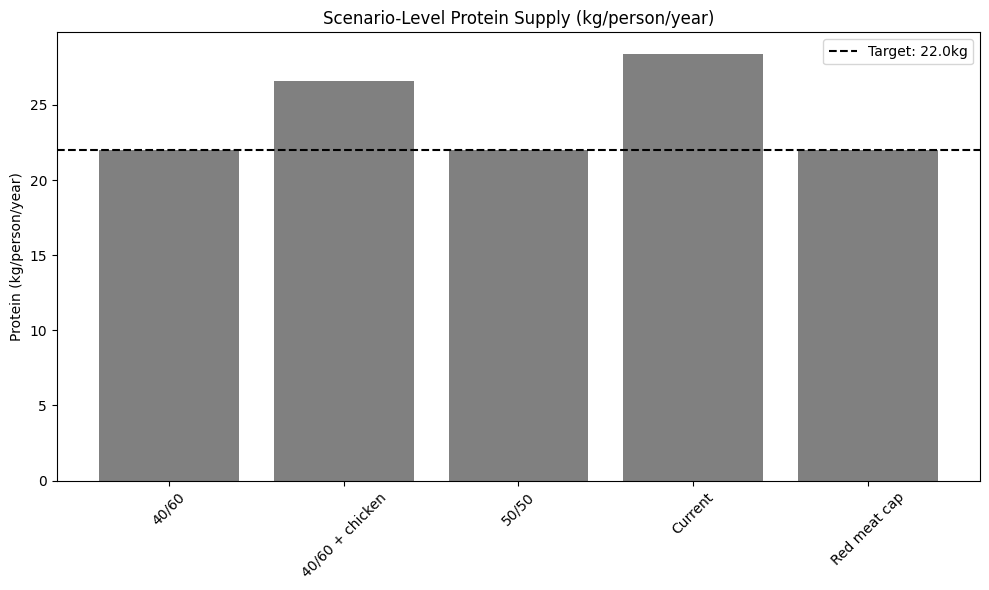

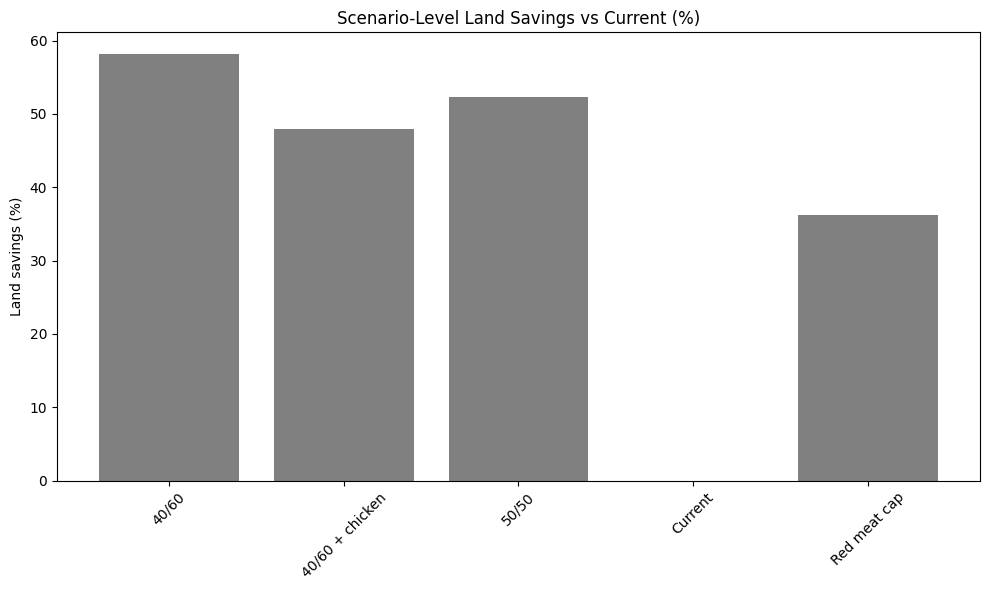

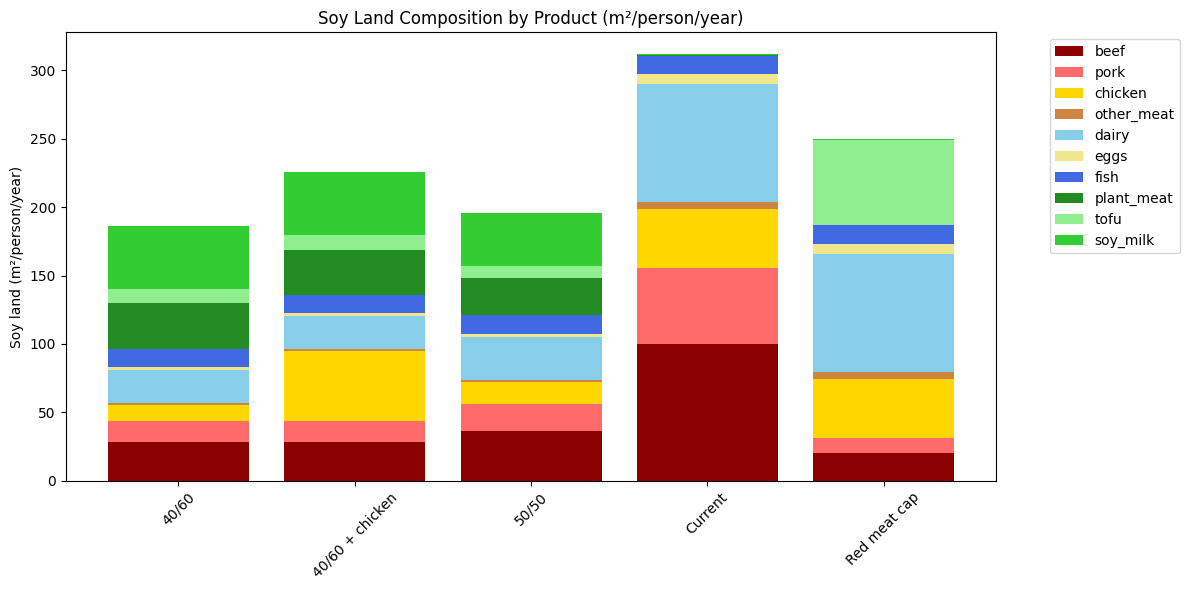

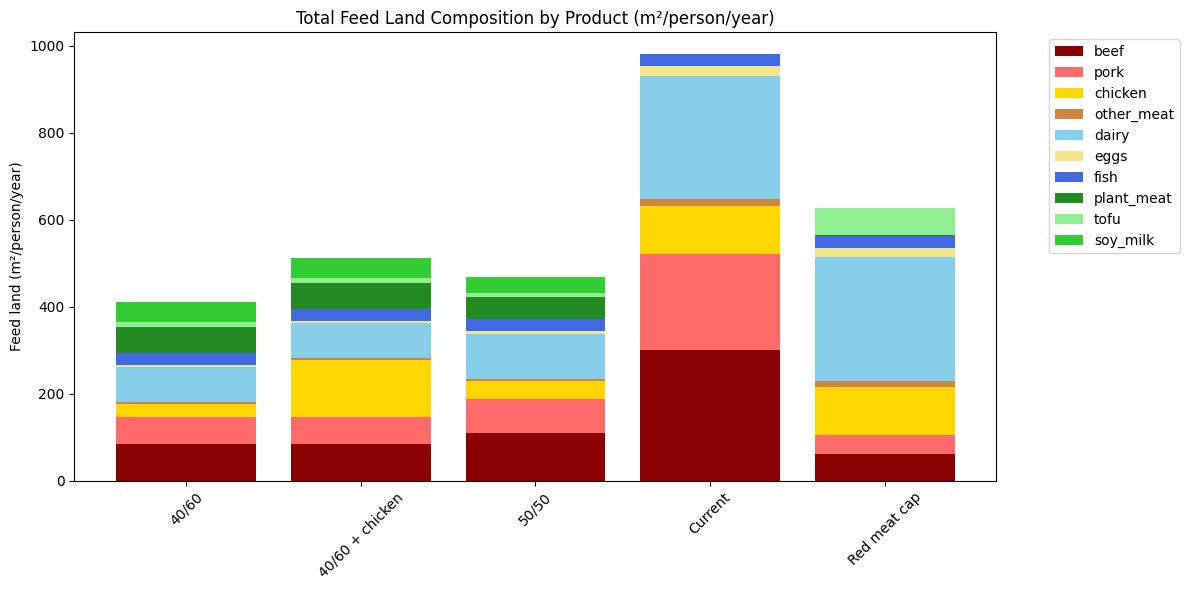

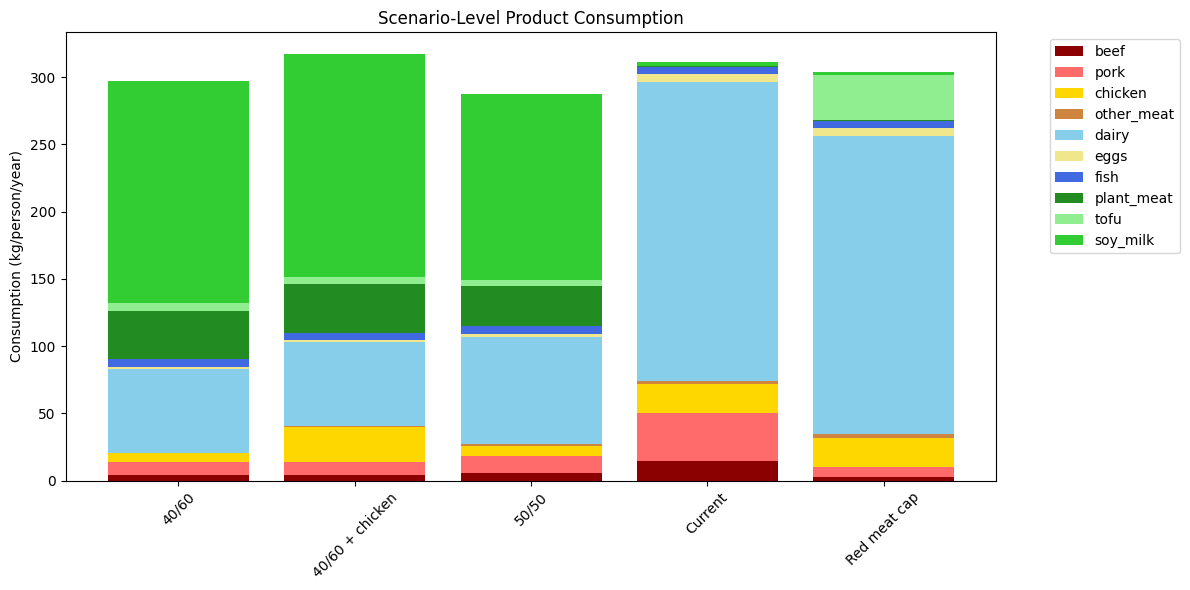

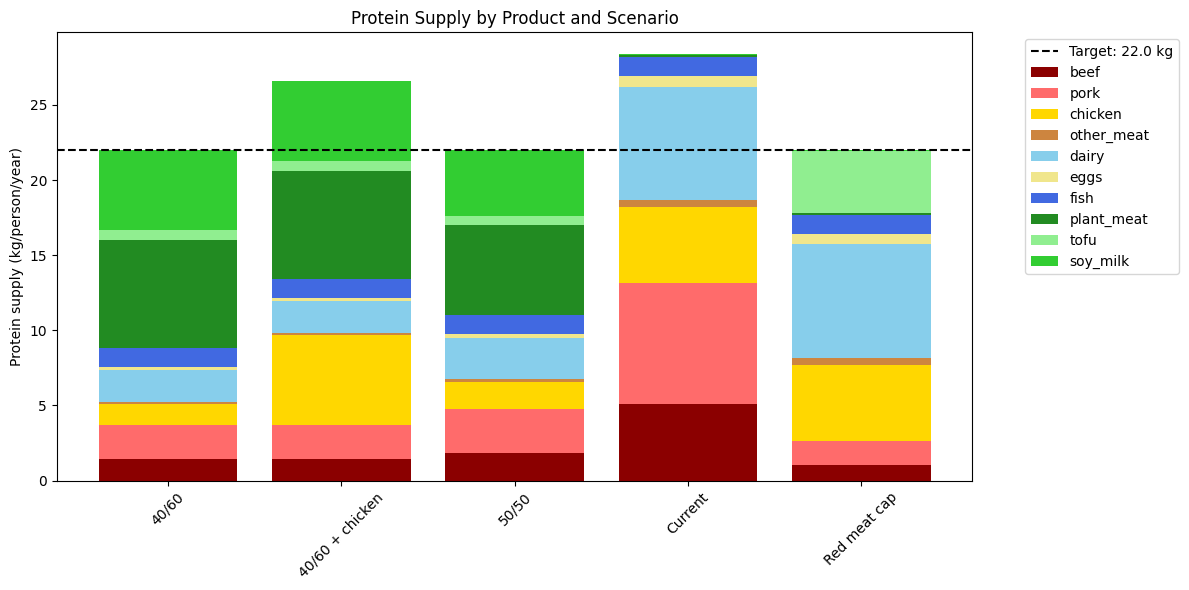

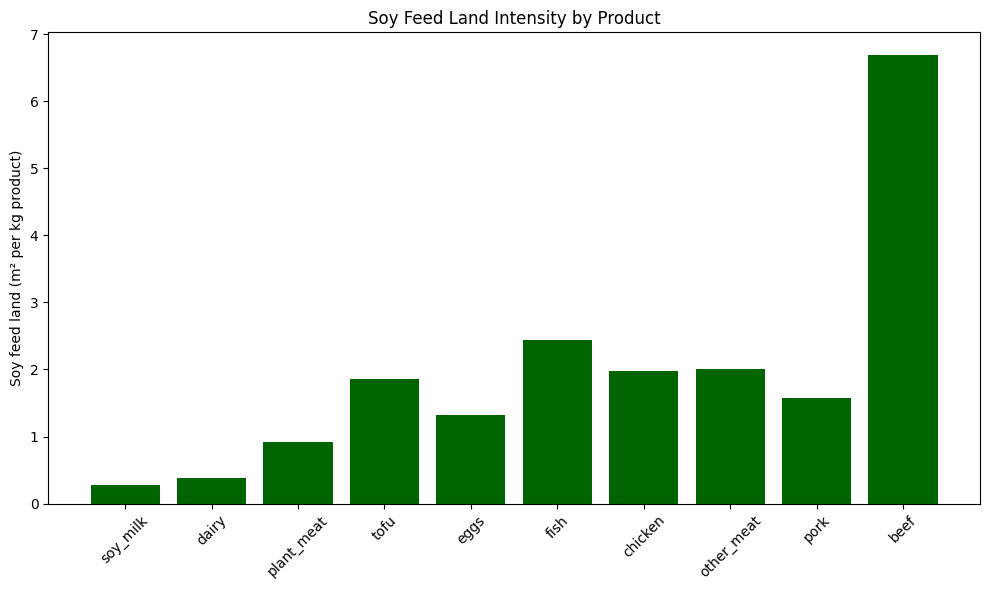

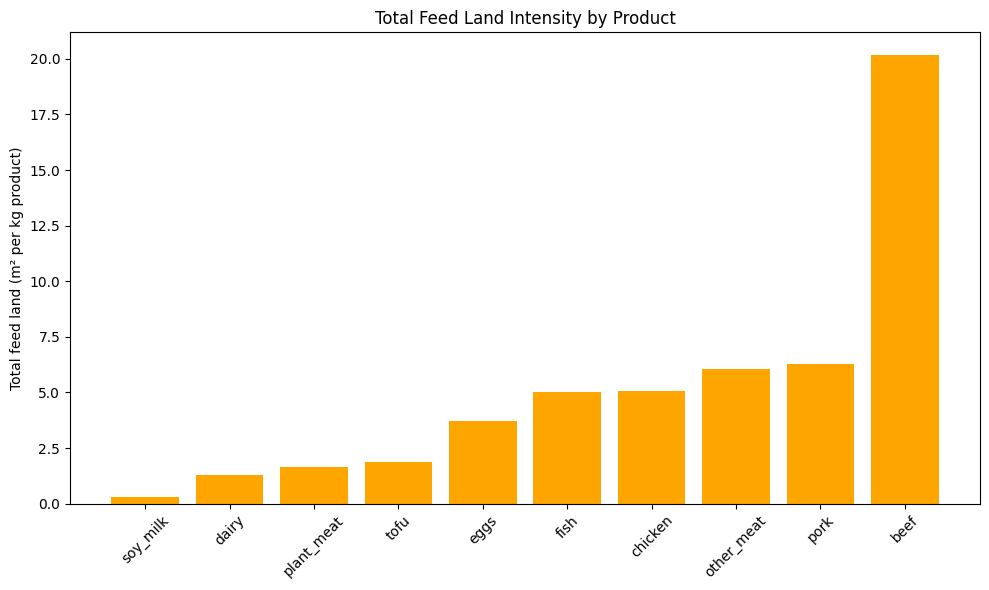

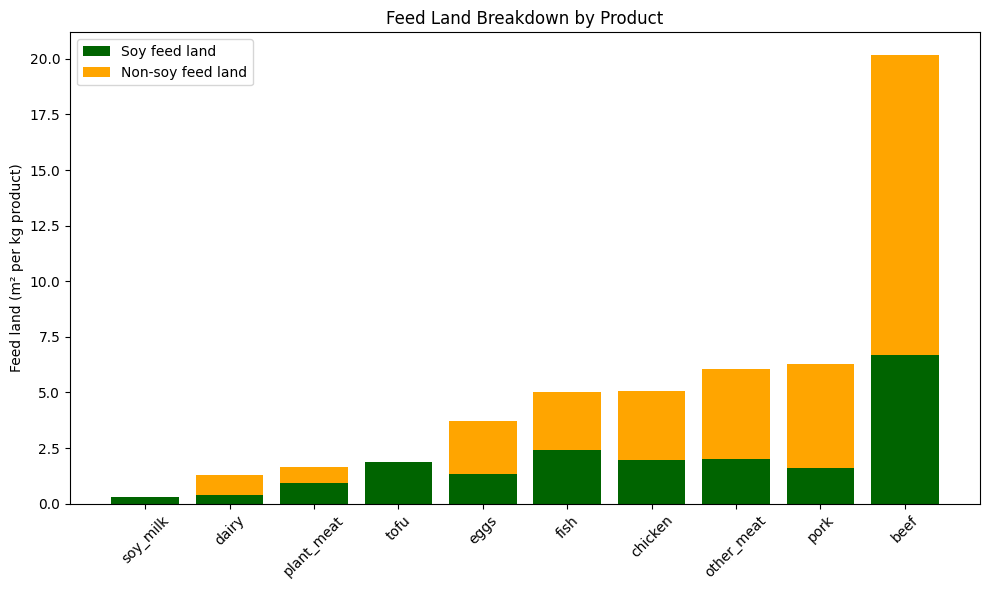

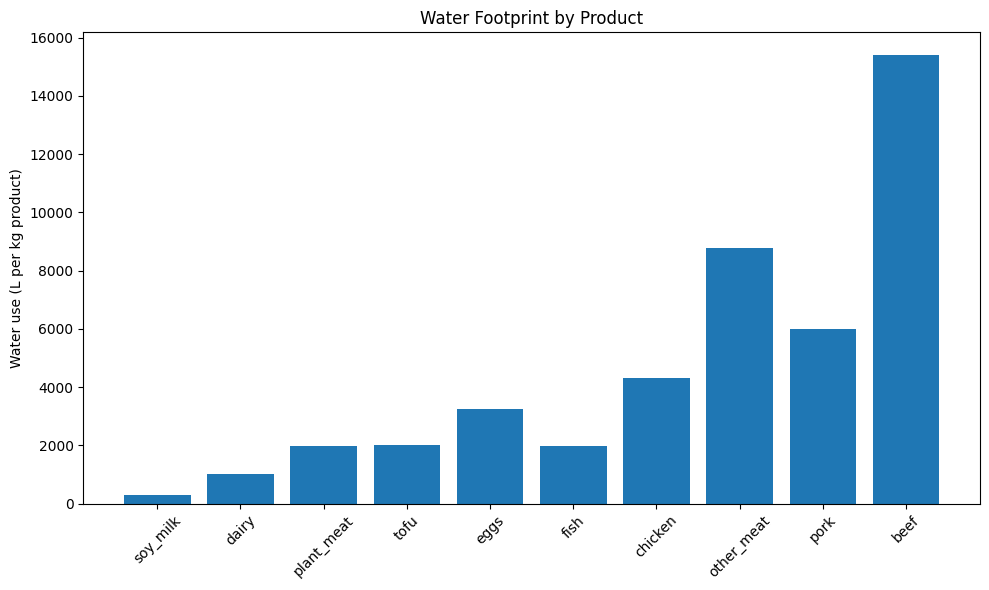

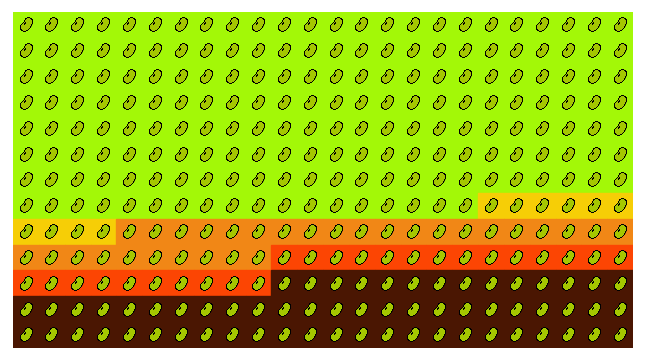

In [1]:
# ============================================
# DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION
# Organized script: setup, tables, then plots
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

print("=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===")

# ============================================
# 0. CONFIG
# ============================================

NL_POPULATION = 18_044_027  # 2025
PROTEIN_TARGET = 22.0  # kg protein/person/year

# Base product consumption (kg/person/year)
meat_2024_pc = {"pork": 35.1, "chicken": 22.0, "beef": 14.9, "other_meat": 2.4}
DAIRY_KG_PC = 222.0
EGGS_KG_PC = 5.840
FISH_KG_PC = 5.475  # 15 g/day guideline
PLANT_MEAT_KG_PC = 10_200_000 / NL_POPULATION
TOFU_KG_PC = 1_630_000 / NL_POPULATION
SOY_MILK_KG_PC = 47_100_000 / NL_POPULATION

# Feed crop land (m²/kg)
CROP_LAND_M2_KG = {"maize":0.97, "wheat":1.18, "barley":1.53, "rapeseed":2.65, "soy":2.78}

# Feed shares per product
FEED_SHARES = {
    "dairy": {"maize":0.35, "soy":0.14, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.15, "other":0.03},
    "beef": {"maize":0.25, "soy":0.12, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.35, "other":0.02},
    "pork": {"maize":0.45, "soy":0.12, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.0, "other":0.10},
    "poultry": {"maize":0.55, "soy":0.20, "wheat_barley":0.15, "rapeseed":0.05, "grass_hay":0.0, "other":0.05},
    "eggs": {"maize":0.50, "soy":0.18, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.0, "other":0.06},
    "fish": {"maize":0.20, "soy":0.25, "wheat_barley":0.30, "rapeseed":0.05, "grass_hay":0.0, "other":0.20},
    "plant_meat": {"maize":0.15, "soy":0.33, "wheat_barley":0.40, "rapeseed":0.02, "grass_hay":0.0, "other":0.10},
    "plant_milk": {"maize":0.10, "soy":0.33, "wheat_barley":0.10, "rapeseed":0.02, "grass_hay":0.0, "other":0.45}
}

# Color mapping for products
prod_colors = {
    "beef": "#8B0000",
    "pork": "#FF6B6B",
    "chicken": "#FFD700",
    "other_meat": "#CD853F",
    "dairy": "#87CEEB",
    "eggs": "#F0E68C",
    "fish": "#4169E1",
    "plant_meat": "#228B22",
    "tofu": "#90EE90",
    "soy_milk": "#32CD32"
}

# ============================================
# 1. PRODUCTS DATAFRAME
# ============================================

products = [
    ("pork",4.74,230,"pork"),
    ("chicken",3.55,230,"poultry"),
    ("beef",20.06,340,"beef"),
    ("other_meat",6.00,200,"beef"),
    ("fish",3.50,230,"fish"),
    ("plant_meat",1.00,200,"plant_meat"),
    ("dairy",1,34,"dairy"),
    ("eggs",2.63,123,"eggs"),
    ("tofu",0.67,124,None),
    ("soy_milk",0.1,32,None)
]

df = pd.DataFrame(products, columns=["product","emcr","protein_g_kg","feed_type"])
df["soy_share"] = 0.0
df["soy_land"] = 0.0
df["non_soy_land"] = 0.0
df["total_land"] = 0.0
df["water_L_kg"] = [5988,4325,15415,8763,1974,1973,1020,3265,2000,297]

def compute_feed_land(emcr, feed_type):
    if feed_type is None:
        soy_land = emcr * CROP_LAND_M2_KG["soy"]
        return 1.0, soy_land, 0.0
    shares = FEED_SHARES[feed_type]
    soy_land = emcr * shares["soy"] * CROP_LAND_M2_KG["soy"]
    maize_kg = emcr * shares["maize"]
    wbar_kg = emcr * shares["wheat_barley"]
    rape_kg = emcr * shares["rapeseed"]
    non_soy_land = (
        maize_kg * CROP_LAND_M2_KG["maize"] +
        wbar_kg * (0.5*CROP_LAND_M2_KG["wheat"] + 0.5*CROP_LAND_M2_KG["barley"]) +
        rape_kg * CROP_LAND_M2_KG["rapeseed"]
    )
    return shares["soy"], soy_land, non_soy_land

for idx,row in df.iterrows():
    soy_share, soy_land, non_soy_land = compute_feed_land(row["emcr"], row["feed_type"])
    df.at[idx,"soy_share"]=soy_share
    df.at[idx,"soy_land"]=soy_land
    df.at[idx,"non_soy_land"]=non_soy_land
    df.at[idx,"total_land"]=soy_land+non_soy_land

# ============================================
# 2. HELPER FUNCTION
# ============================================

def add(rows, scenario, prod, kg):
    r = df.loc[df["product"]==prod].iloc[0]
    rows.append({
        "scenario": scenario,
        "product": prod,
        "kg_pc": kg,
        "protein_pc": kg * r.protein_g_kg / 1000,
        "soy_land_pc": kg * r.soy_land,
        "total_land_pc": kg * r.total_land,
        "water_pc": kg * r.water_L_kg
    })

# ============================================
# 3. SCENARIO BUILDER
# ============================================

def scale_to_protein(products_dict, target_protein):
    protein_per_kg = {p: df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in products_dict}
    total_protein_current = sum(products_dict[p]*protein_per_kg[p] for p in products_dict)
    factor = target_protein / total_protein_current
    return {p: products_dict[p]*factor for p in products_dict}

def build_scenarios():
    scenarios=[]
    
    current_dict = {**meat_2024_pc,"dairy":DAIRY_KG_PC,"eggs":EGGS_KG_PC,"fish":FISH_KG_PC,
                    "plant_meat":PLANT_MEAT_KG_PC,"tofu":TOFU_KG_PC,"soy_milk":SOY_MILK_KG_PC}
    for prod,kg in current_dict.items():
        add(scenarios,"Current",prod,kg)

    # 15g fish/day guideline
    fish_protein = FISH_KG_PC * df.loc[df["product"]=="fish","protein_g_kg"].iloc[0]/1000

    # 40/60 scenario
    animal_products = {k:current_dict[k] for k in ["pork","chicken","beef","other_meat","dairy","eggs"]}
    plant_products = {k:current_dict[k] for k in ["plant_meat","tofu","soy_milk"]}

    animal_scaled = scale_to_protein(animal_products, PROTEIN_TARGET*0.4 - fish_protein)
    plant_scaled = scale_to_protein(plant_products, PROTEIN_TARGET*0.6)

    for prod,kg in {**animal_scaled, **plant_scaled}.items():
        add(scenarios,"40/60",prod,kg)
    add(scenarios,"40/60","fish",FISH_KG_PC)

    # 40/60 + chicken
    for prod,kg in {**animal_scaled, **plant_scaled}.items():
        add(scenarios,"40/60 + chicken",prod,kg)
    add(scenarios,"40/60 + chicken","fish",FISH_KG_PC)
    add(scenarios,"40/60 + chicken","chicken",20)

    # 50/50
    animal_scaled_5050 = scale_to_protein(animal_products, PROTEIN_TARGET*0.5 - fish_protein)
    plant_scaled_5050 = scale_to_protein(plant_products, PROTEIN_TARGET*0.5)

    for prod,kg in {**animal_scaled_5050, **plant_scaled_5050}.items():
        add(scenarios,"50/50",prod,kg)
    add(scenarios,"50/50","fish",FISH_KG_PC)

    # Red meat cap
    current_red_meat = current_dict["beef"] + current_dict["pork"]
    scale = 10.0 / current_red_meat
    red_meat_cap = { "beef": current_dict["beef"]*scale, "pork": current_dict["pork"]*scale }
    rest_products = {k:current_dict[k] for k in current_dict if k not in red_meat_cap}
    protein_from_red = sum(red_meat_cap[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in red_meat_cap)
    protein_rest = sum(rest_products[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in rest_products)
    protein_gap = max(0, PROTEIN_TARGET - (protein_from_red + protein_rest))

    for prod,kg in red_meat_cap.items():
        add(scenarios,"Red meat cap",prod,kg)
    for prod,kg in rest_products.items():
        add(scenarios,"Red meat cap",prod,kg)
    if protein_gap>0:
        prot_per_kg_tofu = df.loc[df["product"]=="tofu","protein_g_kg"].iloc[0]/1000
        add(scenarios,"Red meat cap","tofu",protein_gap/prot_per_kg_tofu)

    return pd.DataFrame(scenarios)

all_scenarios = build_scenarios()

# ============================================
# 4. SUMMARY TABLES
# ============================================

# Scenario summary
agg_pc = all_scenarios.groupby("scenario")[["soy_land_pc","total_land_pc","water_pc","protein_pc"]].sum()
print("\n=== SCENARIO SUMMARY ===")
print(agg_pc.round(2))

# Product-level summary
product_summary = df.set_index("product")[["soy_share","soy_land","non_soy_land","total_land","protein_g_kg","water_L_kg"]].round(3)
print("\n=== PRODUCT-LEVEL FEED LAND SUMMARY (per kg product) ===")
print(product_summary)

# Scenario-level product consumption
pivot_kg = all_scenarios.pivot_table(index="scenario", columns="product", values="kg_pc", aggfunc="sum", fill_value=0)
print("\n=== Scenario-Level Product Consumption (kg/person/year) ===")
print(pivot_kg.round(2))

# Scenario-level protein supply
pivot_protein = all_scenarios.pivot_table(index="scenario", columns="product", values="protein_pc", aggfunc="sum", fill_value=0)
print("\n=== Protein Supply by Product and Scenario (kg/person/year) ===")
print(pivot_protein.round(2))

# Full summary
summary_table = agg_pc.join(pivot_kg.add_suffix("_kg")).join(pivot_protein.add_suffix("_protein"))
print("\n=== Full Scenario Summary Table ===")
print(summary_table.round(2))

# ============================================
# 5. PLOTS: SCENARIO-LEVEL
# ============================================

pivot = all_scenarios.pivot_table(index="scenario", columns="product", values="total_land_pc", aggfunc="sum", fill_value=0)
pivot_soy = all_scenarios.pivot_table(index="scenario", columns="product", values="soy_land_pc", aggfunc="sum", fill_value=0)

# --- Soy land ---
plt.figure(figsize=(10,6))
plt.bar(agg_pc.index, agg_pc["soy_land_pc"], color="darkgreen")
plt.title("Scenario-Level Soy Land (m²/person/year)")
plt.ylabel("Soy land (m²/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Total feed land ---
plt.figure(figsize=(10,6))
plt.bar(agg_pc.index, agg_pc["total_land_pc"], color="orange")
plt.title("Scenario-Level Total Feed Land (m²/person/year)")
plt.ylabel("Total feed land (m²/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Water ---
plt.figure(figsize=(10,6))
plt.bar(agg_pc.index, agg_pc["water_pc"]/1e6, color="blue")
plt.title("Scenario-Level Water Use (million L/person/year)")
plt.ylabel("Water (million L/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Protein ---
plt.figure(figsize=(10,6))
plt.bar(agg_pc.index, agg_pc["protein_pc"], color="grey")
plt.title("Scenario-Level Protein Supply (kg/person/year)")
plt.ylabel("Protein (kg/person/year)")
plt.axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET}kg")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Land savings ---
plt.figure(figsize=(10,6))
current_total = agg_pc.loc["Current","total_land_pc"]
land_savings = [(1 - v/current_total)*100 for v in agg_pc["total_land_pc"]]
plt.bar(agg_pc.index, land_savings, color="grey")
plt.title("Scenario-Level Land Savings vs Current (%)")
plt.ylabel("Land savings (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Soy land composition by product ---
plt.figure(figsize=(12,6))
bottom = np.zeros(len(pivot_soy))
for prod in prod_colors:
    if prod in pivot_soy.columns:
        plt.bar(pivot_soy.index, pivot_soy[prod], bottom=bottom, color=prod_colors[prod], label=prod)
        bottom += pivot_soy[prod].values
plt.title("Soy Land Composition by Product (m²/person/year)")
plt.ylabel("Soy land (m²/person/year)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Total feed land composition by product ---
plt.figure(figsize=(12,6))
bottom = np.zeros(len(pivot))
for prod in prod_colors:
    if prod in pivot.columns:
        plt.bar(pivot.index, pivot[prod], bottom=bottom, color=prod_colors[prod], label=prod)
        bottom += pivot[prod].values
plt.title("Total Feed Land Composition by Product (m²/person/year)")
plt.ylabel("Feed land (m²/person/year)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Scenario-level product consumption ---
fig, ax = plt.subplots(figsize=(12,6))
bottom = np.zeros(len(pivot_kg))
for prod in prod_colors:
    if prod in pivot_kg.columns:
        ax.bar(range(len(pivot_kg)), pivot_kg[prod], bottom=bottom, color=prod_colors[prod], label=prod)
        bottom += pivot_kg[prod].values
ax.set_xticks(range(len(pivot_kg)))
ax.set_xticklabels(pivot_kg.index, rotation=45)
ax.set_ylabel("Consumption (kg/person/year)")
ax.set_title("Scenario-Level Product Consumption")
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Protein supply by product ---
fig, ax = plt.subplots(figsize=(12,6))
bottom = np.zeros(len(pivot_protein))
for prod in prod_colors:
    if prod in pivot_protein.columns:
        ax.bar(range(len(pivot_protein)), pivot_protein[prod], bottom=bottom, color=prod_colors[prod], label=prod)
        bottom += pivot_protein[prod].values
ax.set_xticks(range(len(pivot_protein)))
ax.set_xticklabels(pivot_protein.index, rotation=45)
ax.set_ylabel("Protein supply (kg/person/year)")
ax.set_title("Protein Supply by Product and Scenario")
ax.axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET} kg")
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# ============================================
# 6. PRODUCT-LEVEL FOOTPRINTS
# ============================================

df_sorted = df.sort_values("total_land")

# --- Soy feed land ---
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["soy_land"], color="darkgreen")
plt.ylabel("Soy feed land (m² per kg product)")
plt.title("Soy Feed Land Intensity by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Total feed land ---
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["total_land"], color="orange")
plt.ylabel("Total feed land (m² per kg product)")
plt.title("Total Feed Land Intensity by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Feed land breakdown (soy vs non-soy) ---
plt.figure(figsize=(10,6))
bottom = np.zeros(len(df_sorted))
plt.bar(df_sorted["product"], df_sorted["soy_land"], bottom=bottom, color="darkgreen", label="Soy feed land")
bottom += df_sorted["soy_land"].values
plt.bar(df_sorted["product"], df_sorted["non_soy_land"], bottom=bottom, color="orange", label="Non-soy feed land")
plt.ylabel("Feed land (m² per kg product)")
plt.title("Feed Land Breakdown by Product")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Water footprint ---
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["water_L_kg"], color="tab:blue")
plt.ylabel("Water use (L per kg product)")
plt.title("Water Footprint by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================================
# 7. SOYBEAN WAFFLE PLOT
# ============================================

# Soy land per scenario (rounded for visualization)
soy_land_pc = {
    "Current": 312,
    "Red meat cap": 250,
    "40/60 + chicken": 226,
    "50/50": 196,
    "40/60": 186
}

# Order scenarios
scenario_order = ["40/60", "50/50", "40/60 + chicken", "Red meat cap", "Current"]

# Colors for scenarios
colors = {
    "40/60": "#a3f807",
    "50/50": "#f6ce06",
    "40/60 + chicken": "#f18716",
    "Red meat cap": "#fc4503",
    "Current": "#4A1602"
}

# Load soybean icon
icon_path = "soybean.png"
soy_icon = Image.open(icon_path)

# Waffle config
n_cols = 24
n_rows = 13
icon_zoom = 0.05

# Scenario differences
prev = 0
scenario_diff = {}
for sc in scenario_order:
    scenario_diff[sc] = soy_land_pc[sc] - prev
    prev = soy_land_pc[sc]

# Create figure
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
ax.set_xlim(0, n_cols)
ax.set_ylim(0, n_rows)
ax.axis('off')

# Draw colored squares
current_idx = 0
for sc in scenario_order:
    for i in range(scenario_diff[sc]):
        x = current_idx % n_cols
        y = n_rows - 1 - current_idx // n_cols
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=colors[sc], zorder=0))
        current_idx += 1

# Overlay soybeans
for i in range(prev):
    x = i % n_cols
    y = n_rows - 1 - i // n_cols
    imagebox = OffsetImage(soy_icon, zoom=icon_zoom)
    ab = AnnotationBbox(imagebox, (x+0.5, y+0.5), frameon=False, zorder=1)
    ax.add_artist(ab)

plt.show()
